In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import cv2
from tensorflow.keras import layers, models

In [12]:
# -----------------------------
# PARAMETERS
# -----------------------------
data_dir = "./dataset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
AUG_FACTOR = 10  # how many times each image is augmented during training
EPOCHS = 10      # adjust as needed

In [13]:
# -----------------------------
# LOAD FILES & LABELS
# -----------------------------
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c:i for i,c in enumerate(classes)}

all_image_paths = []
all_labels = []

for cls in classes:
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([class_to_index[cls]] * len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Classes:", classes)
print("Original dataset size:", len(all_image_paths))

Classes: ['normal', 'osteoporosis']
Original dataset size: 372


In [14]:
# -----------------------------
# NORMALIZATION FUNCTION
# -----------------------------
def normalize_image(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

# -----------------------------
# STRONG AUGMENTATION FUNCTION
# -----------------------------
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=k)
    return img, label


In [15]:
# -----------------------------
# BUILD BASE DATASET
# -----------------------------
dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))
dataset = dataset.map(normalize_image, num_parallel_calls=AUTOTUNE)

In [16]:
# -----------------------------
# SPLIT TRAIN / VAL / TEST (70/15/15)
# -----------------------------
dataset_size = len(all_image_paths)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

dataset = dataset.shuffle(dataset_size, reshuffle_each_iteration=False)
train_ds = dataset.take(train_size)
val_test_ds = dataset.skip(train_size)
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

print("Train size:", sum(1 for _ in train_ds))
print("Val size  :", sum(1 for _ in val_ds))
print("Test size :", sum(1 for _ in test_ds))


Train size: 260
Val size  : 55
Test size : 57


In [17]:
# -----------------------------
# APPLY AUGMENTATION ON TRAIN SET
# -----------------------------
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE).repeat(AUG_FACTOR)
train_ds = train_ds.shuffle(buffer_size=train_size * AUG_FACTOR)

In [18]:
# -----------------------------
# BATCH & PREFETCH
# -----------------------------
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [19]:
# -----------------------------
# BUILD EFFICIENTNETB0 MODEL
# -----------------------------
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,  # train from scratch
    input_shape=(224, 224, 3)
)
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 4,171,645 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [20]:
# -----------------------------
# TRAIN THE MODEL
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step - accuracy: 0.5962 - loss: 0.6773 - val_accuracy: 0.5091 - val_loss: 0.7052
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.6881 - loss: 0.5993 - val_accuracy: 0.5091 - val_loss: 0.6971
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.7115 - loss: 0.5586 - val_accuracy: 0.5091 - val_loss: 0.6963
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.7500 - loss: 0.5113 - val_accuracy: 0.5091 - val_loss: 0.9795
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.7669 - loss: 0.4829 - val_accuracy: 0.6909 - val_loss: 0.6657
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 534s 3s/step - accuracy: 0.7885 - loss: 0.4381 - val_accuracy: 0.7091 - val_loss: 0.7847
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.8023 - loss: 0.4176 - val_accuracy: 0.7273 - val_loss: 0.7520
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.8296 - loss: 0.3688 - val_accu


Train -> Accuracy: 0.9153846153846154
              precision    recall  f1-score   support

      normal       0.93      0.90      0.91      1290
osteoporosis       0.91      0.93      0.92      1310

    accuracy                           0.92      2600
   macro avg       0.92      0.92      0.92      2600
weighted avg       0.92      0.92      0.92      2600



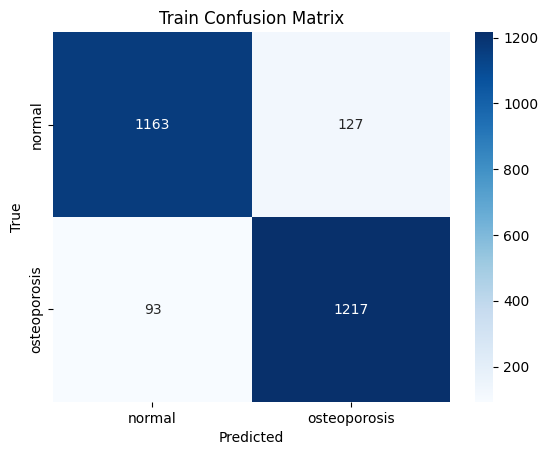


Val -> Accuracy: 0.6181818181818182
              precision    recall  f1-score   support

      normal       0.60      0.67      0.63        27
osteoporosis       0.64      0.57      0.60        28

    accuracy                           0.62        55
   macro avg       0.62      0.62      0.62        55
weighted avg       0.62      0.62      0.62        55



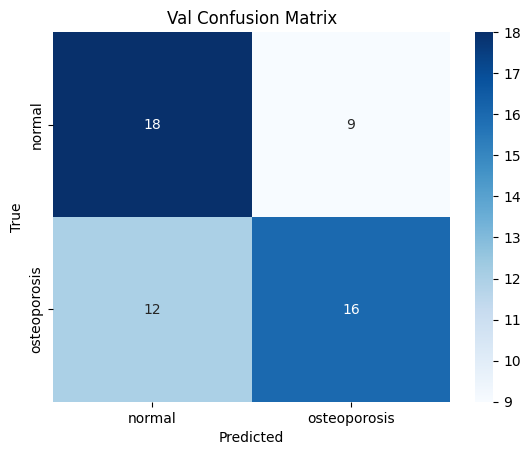


Test -> Accuracy: 0.6842105263157895
              precision    recall  f1-score   support

      normal       0.71      0.67      0.69        30
osteoporosis       0.66      0.70      0.68        27

    accuracy                           0.68        57
   macro avg       0.68      0.69      0.68        57
weighted avg       0.69      0.68      0.68        57



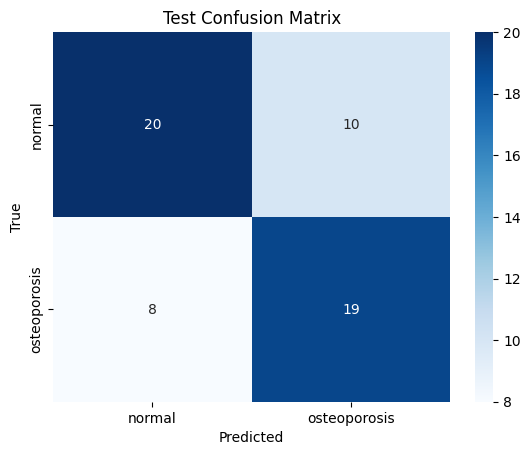

In [22]:
# -----------------------------
# EVALUATION FUNCTION
# -----------------------------
def evaluate_and_report(model, dataset, split_name="Validation"):
    y_true, y_pred = [], []
    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    print(f"\n{split_name} -> Accuracy:", np.mean(np.array(y_true) == np.array(y_pred)))
    print(classification_report(y_true, y_pred, target_names=classes))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# -----------------------------
# EVALUATE MODEL
# -----------------------------
evaluate_and_report(model, train_ds, "Train")
evaluate_and_report(model, val_ds, "Val")
evaluate_and_report(model, test_ds, "Test")